In [13]:
import pandas as ps

import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.svm import LinearSVC

from gensim import models

import warnings 
warnings.simplefilter('ignore')

from proj2_helpers import *
from get_embeddings_ML import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [21]:
from  word2vect_utilities import *

In [22]:
from nltk import word_tokenize, WordNetLemmatizer

### DATA LOADING

In [5]:
RESULT_POS_PATH = './Results/pp_pos_otpl_nd.txt'
RESULT_NEG_PATH = './Results/pp_neg_otpl_nd.txt'
RES_PATH = './Results/pp_test_otpl.txt'

In [6]:
# load the data files = list with each line being a tweet
result_pos = open(RESULT_POS_PATH, "r").read().splitlines()
result_neg = open(RESULT_NEG_PATH, "r").read().splitlines()
test_set = open(RES_PATH, "r").read().splitlines()

### DATAFRAME CONSTRUCTION

In [23]:
#-----------------------------------------TRAINING SET---------------------------------------------------------------------------

# create labels
label_pos = [1] * len(result_pos)
#create a df
pos_df = pd.DataFrame(list(zip(label_pos, result_pos)),columns=["Sentiment","Tweet"]) 
del label_pos

# create labels
label_neg = [-1] * len(result_neg)
# create a df
neg_df = pd.DataFrame(list(zip(label_neg, result_neg)),columns=["Sentiment","Tweet"]) #create a df
del label_neg

# regroup the dfs, ignore index in order to get new ones (->no duplicate)
train_df = pd.concat([pos_df,neg_df],ignore_index=True) #regroup the dfs, ignore index in order to get new ones (->no duplicate)

train_tokens = [word_tokenize(sen) for sen in train_df.Tweet] 

train_df['tokens'] = train_tokens

# shuffle the rows
train_df = train_df.sample(frac=1) 

In [42]:
train_df

,Sentiment,Tweet,tokens
157305,-1,leader make difference leadership lessons thre...,"[leader, make, difference, leadership, lessons..."
30949,1,maura maria,"[maura, maria]"
29427,1,big butt unless like mao,"[big, butt, unless, like, mao]"
159526,-1,fabulous get work official video via feel like...,"[fabulous, get, work, official, video, via, fe..."
129790,-1,cry friend talk fun dint call text still befri...,"[cry, friend, talk, fun, dint, call, text, sti..."
...,...,...,...
94340,-1,caleb need stop harass follow back shit sorry ...,"[caleb, need, stop, harass, follow, back, shit..."
140815,-1,photo wall pro collage app free phone app phot...,"[photo, wall, pro, collage, app, free, phone, ..."
3021,1,jealous girlfriend faithful girlfriend babe ge...,"[jealous, girlfriend, faithful, girlfriend, ba..."
103897,-1,kill clean next bin outside jasmine wet stuff ...,"[kill, clean, next, bin, outside, jasmine, wet..."


In [24]:
#-----------------------------------------TEST SET---------------------------------------------------------------------------
test_ids = np.linspace(1,10000,10000, dtype=int)
# create a df
test_df = pd.DataFrame(list(zip(test_ids, test_set)), columns=["Tweet_submission_id","Tweet"]) 

test_tokens = [word_tokenize(sen) for sen in test_df.Tweet] 

test_df['tokens'] = test_tokens

### WORD EMBEDDING

In [25]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [26]:
all_training_words = [word for tokens in train_df["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in train_df["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

1199577 words total, with a vocabulary size of 42148
Max sentence length is 26


In [28]:
training_embeddings = get_word2vec_embeddings(word2vec, train_df, generate_missing=True)

In [34]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

#### Tokenize and Pad sequences

In [29]:
EMBEDDING_DIM = 20

In [32]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(train_df["Tweet"].tolist())
training_sequences = tokenizer.texts_to_sequences(train_df["Tweet"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 42146 unique tokens.


In [35]:
train_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [36]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(42147, 300)


In [37]:
x_train = train_data

In [43]:
y_train = train_df.Sentiment.values

In [44]:
test_sequences = tokenizer.texts_to_sequences(test_df["Tweet"].tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

#### PCA 

In [46]:
scaler = MinMaxScaler(feature_range=[0, 1])
X_rescaled = scaler.fit_transform(x_train)
test_rescaled = scaler.fit_transform(test_data)

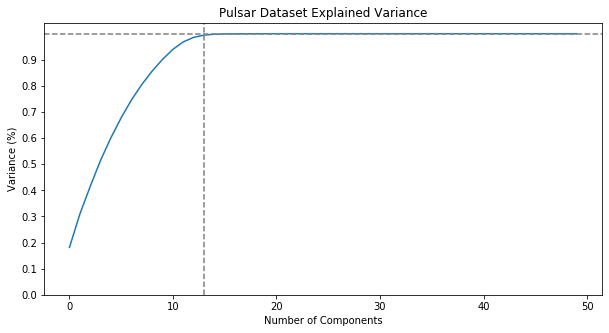

In [47]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
fig = plt.figure(figsize=(10,5))
x=np.cumsum(pca.explained_variance_ratio_)
plt.plot(x)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.yticks(np.arange(0, 1, 0.1))
plt.axhline(y=1,color='gray',linestyle='--')
plt.axvline(x=13,color='gray',linestyle='--')
plt.show()

We see that we have selecting 13 components we can preserve the total variance of the data.

In [49]:
pca = PCA(n_components=13)
train_vals = pca.fit_transform(X_rescaled)
test= pca.fit_transform(test_rescaled)

### SVM

In [50]:
svc = LinearSVC()
svc.fit(train_vals, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [51]:
y_pred = svc.predict(test)

In [52]:
len(y_pred)

10000

### CREATE SUBMISSION

In [53]:
test_id = test_df['Tweet_submission_id'].to_numpy()

In [54]:
len(test_id)

10000

In [55]:
create_csv_submission(test_id,y_pred, "./Submissions/SVM_SUB.csv")